# Linear Support Vector Machine: Soft Margin
----------------------------------

This function shows how to use TensorFlow to create a soft margin SVM

We will use the iris data, specifically:
x1 = Sepal Length
x2 = Petal Width

Class 1 : I. setosa
Class -1: not I. setosa

We know here that x and y are linearly seperable for I. setosa classification.

Note that we implement the soft margin with an allowable margin of error for points.  The margin of error term is given by 'alpha' below.  To behave like a hard margin SVM, set alpha = 0. (in notebook code block #7)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

Start a computational graph.

In [2]:
sess = tf.Session()

Load the data

In [3]:
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

Split data into train/test sets

In [4]:
train_indices = np.random.choice(len(x_vals),
                                 round(len(x_vals)*0.8),
                                 replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until


Set model parameters, placeholders, and coefficients.

In [5]:
# Declare batch size
batch_size = 100

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for SVM
A = tf.Variable(tf.random_normal(shape=[2, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

Declare our model and L2 Norm

SVM linear model is given by the equation:

$$\left[ \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - A \cdot x - b) \right] + \alpha \cdot ||A||^{2}$$

Our loss function will be the above quantity and we will tell TensorFlow to minimize it. Note that $n$ is the number of points (in a batch), $A$ is the hyperplane-normal vector (to solve for), $b$ is the hyperplane-offset (to solve for), and $\alpha$ is the soft-margin parameter.

In [6]:
# Declare model operations
model_output = tf.subtract(tf.matmul(x_data, A), b)

# Declare vector L2 'norm' function squared
l2_norm = tf.reduce_sum(tf.square(A))

Here we make our special loss function based on the classification of the points (which side of the line they fall on).

Also, note that `alpha` is the soft-margin term and an be increased to allow for more erroroneous classification points.  For hard-margin behaviour, set `alpha = 0`.

In [7]:
# Declare loss function
# Loss = max(0, 1-pred*actual) + alpha * L2_norm(A)^2
# L2 regularization parameter, alpha
alpha = tf.constant([0.01])
# Margin term in loss
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_target))))
# Put terms together
loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

Creat the prediction function, optimization algorithm, and initialize the variables.

In [8]:
# Declare prediction function
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

Now we can start the training loop.

In [9]:
# Training loop
loss_vec = []
train_accuracy = []
test_accuracy = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)

    train_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_train,
        y_target: np.transpose([y_vals_train])})
    train_accuracy.append(train_acc_temp)

    test_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_test,
        y_target: np.transpose([y_vals_test])})
    test_accuracy.append(test_acc_temp)

    if (i + 1) % 100 == 0:
        print('Step #{} A = {}, b = {}'.format(
            str(i+1),
            str(sess.run(A)),
            str(sess.run(b))
        ))
        print('Loss = ' + str(temp_loss))

Step #100 A = [[-0.82212186]
 [ 1.01719224]], b = [[-2.32513738]]
Loss = [ 1.05440569]
Step #200 A = [[-0.73883533]
 [ 0.62975895]], b = [[-2.3804369]]
Loss = [ 0.78793252]
Step #300 A = [[-0.64396781]
 [ 0.29083067]], b = [[-2.4325366]]
Loss = [ 0.70990217]
Step #400 A = [[-0.57367617]
 [-0.02292298]], b = [[-2.47833633]]
Loss = [ 0.4520345]
Step #500 A = [[-0.50162601]
 [-0.3186034 ]], b = [[-2.52573752]]
Loss = [ 0.40614846]


Now we extract the linear coefficients and get the SVM boundary line.

In [10]:
# Extract coefficients
[[a1], [a2]] = sess.run(A)
[[b]] = sess.run(b)
slope = -a2/a1
y_intercept = b/a1

# Extract x1 and x2 vals
x1_vals = [d[1] for d in x_vals]

# Get best fit line
best_fit = []
for i in x1_vals:
    best_fit.append(slope*i+y_intercept)

# Separate I. setosa
setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == 1]
setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == 1]
not_setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == -1]
not_setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == -1]

Matplotlib code for plotting

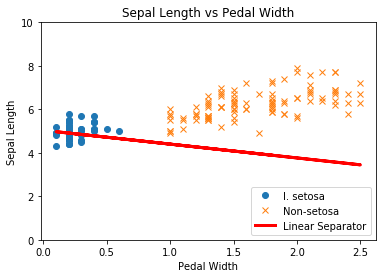

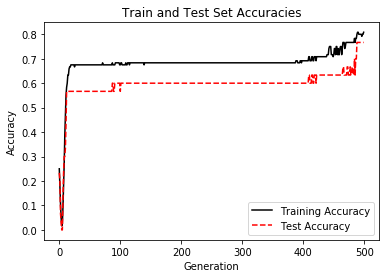

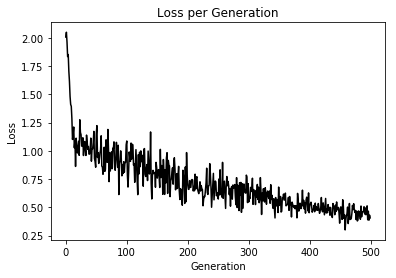

In [11]:
%matplotlib inline
# Plot data and line
plt.plot(setosa_x, setosa_y, 'o', label='I. setosa')
plt.plot(not_setosa_x, not_setosa_y, 'x', label='Non-setosa')
plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot train/test accuracies
plt.plot(train_accuracy, 'k-', label='Training Accuracy')
plt.plot(test_accuracy, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [12]:
import os
merged = tf.summary.merge_all(key='summaries')
if not os.path.exists('tensorboard_logs/'):
    os.makedirs('tensorboard_logs/')

my_writer = tf.summary.FileWriter('tensorboard_logs/', sess.graph)